# Physics-Informed Neural Networks (PINN) Demo

This notebook demonstrates the use of Physics-Informed Neural Networks to solve the wave equation.

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import requests
import contextlib
from src.pinn.pinn_utils import PINN, create_training_data, wave_equation_residual

## Set up MLflow tracking

In [6]:
def is_mlflow_server_up(url="http://localhost:5000"):
    try:
        requests.get(url, timeout=2)
        return True
    except Exception:
        return False

if is_mlflow_server_up():
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("pinn_wave_equation")
    print("Successfully connected to MLflow server")
    USE_MLFLOW = True
else:
    print("Warning: Could not connect to MLflow server. Continuing without experiment tracking.")
    mlflow.set_tracking_uri("file:./mlruns")
    mlflow.set_experiment("pinn_wave_equation")
    USE_MLFLOW = True

2025/06/05 23:28:30 INFO mlflow.tracking.fluent: Experiment with name 'pinn_wave_equation' does not exist. Creating a new experiment.


## Initialize PINN model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model parameters
input_dim = 2  # (x, t)
hidden_layers = [20, 20, 20]
output_dim = 1  # u(x,t)

model = PINN(input_dim, hidden_layers, output_dim).to(device)

Using device: cpu


## Create training data

In [8]:
# Training parameters
n_points = 100
x_range = (-1, 1)
t_range = (0, 1)

x, t = create_training_data(n_points, x_range, t_range, device)

## Training loop

In [9]:
if USE_MLFLOW:
    run_context = mlflow.start_run()
else:
    run_context = contextlib.nullcontext()

with run_context:
    # Log parameters if MLflow is available
    if USE_MLFLOW:
        mlflow.log_params({
            "n_points": n_points,
            "hidden_layers": hidden_layers,
            "x_range": x_range,
            "t_range": t_range
        })
    
    # Training parameters
    n_epochs = 1000
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        # Compute residual
        residual = wave_equation_residual(model, x, t)
        loss = torch.mean(residual**2)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Log metrics
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            if USE_MLFLOW:
                mlflow.log_metric("loss", loss.item(), step=epoch)
    
    # Save model if MLflow is available
    if USE_MLFLOW:
        mlflow.pytorch.log_model(model, "pinn_model")

Epoch 0, Loss: 0.000000
Epoch 100, Loss: 0.000000
Epoch 200, Loss: 0.000000
Epoch 300, Loss: 0.000000
Epoch 400, Loss: 0.000000
Epoch 500, Loss: 0.000000
Epoch 600, Loss: 0.000000
Epoch 700, Loss: 0.000000
Epoch 800, Loss: 0.000000
Epoch 900, Loss: 0.000000


2025/06/05 23:28:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Visualize results

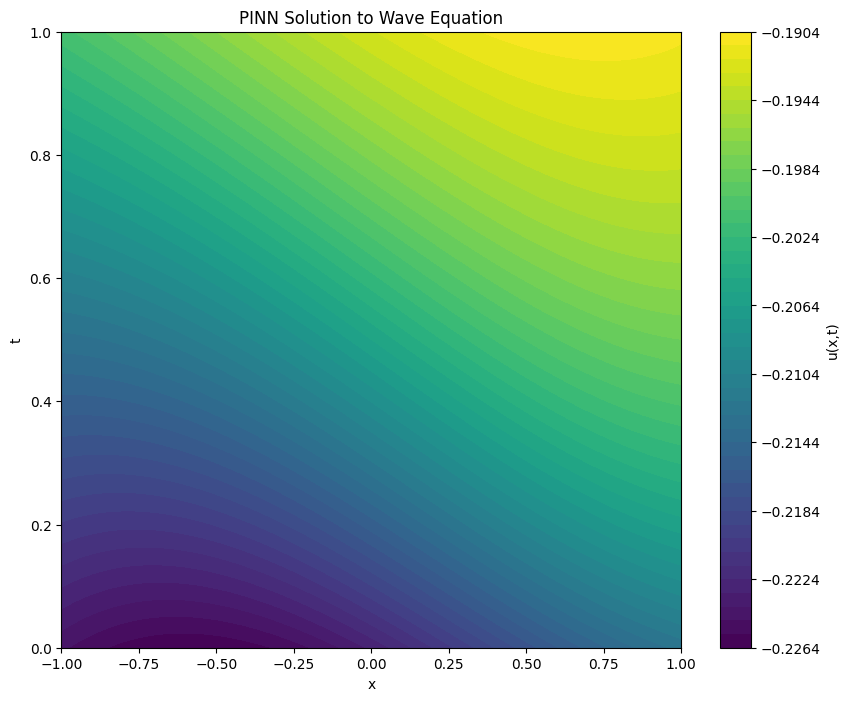

In [10]:
def plot_solution(model, x_range, t_range, n_points=100):
    x = torch.linspace(x_range[0], x_range[1], n_points, device=device)
    t = torch.linspace(t_range[0], t_range[1], n_points, device=device)
    X, T = torch.meshgrid(x, t, indexing='ij')
    
    # Compute solution
    inputs = torch.stack([X.flatten(), T.flatten()], dim=1)
    with torch.no_grad():
        u = model(inputs).reshape(n_points, n_points).cpu().numpy()
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(X.cpu().numpy(), T.cpu().numpy(), u, levels=50)
    plt.colorbar(label='u(x,t)')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('PINN Solution to Wave Equation')
    plt.show()

plot_solution(model, x_range, t_range)